# Importing Libraries

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [2]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb

# Importing Data

## Tickers

In [3]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [4]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [5]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [6]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))
holding.round(5)

,Price in USDT,Weights in %
Total,1955.32494,1.00000
BTCUSDT,816.10741,0.41738
SOLUSDT,285.96957,0.14625
JASMYUSDT,285.40964,0.14597
OMUSDT,201.65496,0.10313
ETHUSDT,191.72194,0.09805
BBUSDT,113.23412,0.05791
TRXUSDT,61.10015,0.03125
BNBUSDT,0.12715,0.00007
PEPEUSDT,0.00000,0.00000


In [7]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)
data=data.sort_index()

In [8]:
inventory_weights=(holding['Weights in %'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

1.0

In [9]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [10]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

### Positions

In [11]:
position=pd.read_excel('Positions.xlsx',index_col=0)

In [12]:
positions=Binance.get_positions_history(enddate=datetime.datetime.today(),
                                        startdate=datetime.datetime(2024,5,5))


2024-05-05 00:00:00
2024-06-04 00:00:00
2024-07-04 00:00:00
2024-08-03 00:00:00
LDUMAUSDT not retrieved
LDUMAUSDT


In [13]:
positions=positions.sort_index()

In [14]:
positions.index=pd.to_datetime(positions.index)

In [15]:
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

In [16]:
positions.to_excel('Positions.xlsx')

In [17]:
positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [18]:
binance_data=Binance.get_price(positions.columns,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change())


LDUMAUSDT not retrieved
Total not retrieved


In [19]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [20]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [21]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<AxesSubplot:>

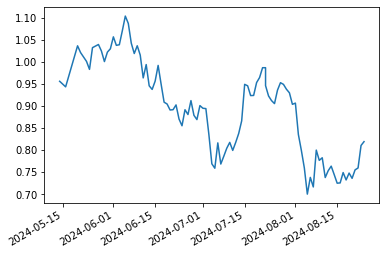

In [22]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()

### Ex ante data

In [23]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

In [24]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [25]:
returns_to_use.columns

Index(['1000SATSUSDT', 'AAVEUSDT', 'ADAUSDT', 'ALGOUSDT', 'APTUSDT', 'ARBUSDT',
       'ARUSDT', 'ATOMUSDT', 'AVAXUSDT', 'AXSUSDT', 'BCHUSDT', 'BNBUSDT',
       'BONKUSDT', 'BTCUSDT', 'DOGEUSDT', 'DOTUSDT', 'DYDXUSDT', 'EGLDUSDT',
       'ENSUSDT', 'EOSUSDT', 'ETCUSDT', 'ETHUSDT', 'FDUSDUSDT', 'FETUSDT',
       'FILUSDT', 'FLOKIUSDT', 'FLOWUSDT', 'FTMUSDT', 'GALAUSDT', 'GRTUSDT',
       'HBARUSDT', 'ICPUSDT', 'IMXUSDT', 'INJUSDT', 'JASMYUSDT', 'LDOUSDT',
       'LINKUSDT', 'LTCUSDT', 'MATICUSDT', 'MKRUSDT', 'NEARUSDT', 'NEOUSDT',
       'OMUSDT', 'OPUSDT', 'ORDIUSDT', 'PEPEUSDT', 'QNTUSDT', 'RUNEUSDT',
       'SANDUSDT', 'SEIUSDT', 'SHIBUSDT', 'SOLUSDT', 'STXUSDT', 'SUIUSDT',
       'THETAUSDT', 'TIAUSDT', 'TRXUSDT', 'UNIUSDT', 'USDCUSDT', 'VETUSDT',
       'WBETHUSDT', 'WBTCUSDT', 'WLDUSDT', 'XECUSDT', 'XLMUSDT', 'XRPUSDT',
       'XTZUSDT'],
      dtype='object')

In [26]:
limit=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0]

## Optimal Portfolio

In [27]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory

,Weights
OMUSDT,0.411941
BTCUSDT,0.400000
BNBUSDT,0.105522
PEPEUSDT,0.062122
JASMYUSDT,0.020416


In [28]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [29]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current

,Weights
TRXUSDT,0.902732
OMUSDT,0.097268


## Real Portfolio vs Optimal

In [30]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights in %']-current_holding_comparison['Weights']
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights in %,Weights,Spread
BTCUSDT,816.107405,4.173769e-01,0.000000,0.000000
SOLUSDT,285.969572,1.462517e-01,0.000000,0.000000
JASMYUSDT,285.409639,1.459653e-01,0.000000,0.000000
OMUSDT,201.654963,1.031312e-01,0.097268,0.005863
ETHUSDT,191.721941,9.805119e-02,0.000000,0.000000
BBUSDT,113.234122,5.791064e-02,0.000000,0.000000
TRXUSDT,61.100146,3.124808e-02,0.902732,-0.871484
BNBUSDT,0.127151,6.502808e-05,0.000000,0.000000
PEPEUSDT,0.000002,1.108358e-09,0.000000,0.000000


In [31]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory],axis=1)
historical_comparison['Spread']=historical_comparison['Weights in %']-historical_comparison['Weights']
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights in %,Weights,Spread
BTCUSDT,816.107405,4.173769e-01,0.400000,0.017377
SOLUSDT,285.969572,1.462517e-01,0.000000,0.000000
JASMYUSDT,285.409639,1.459653e-01,0.020416,0.125549
OMUSDT,201.654963,1.031312e-01,0.411941,-0.308810
ETHUSDT,191.721941,9.805119e-02,0.000000,0.000000
BBUSDT,113.234122,5.791064e-02,0.000000,0.000000
TRXUSDT,61.100146,3.124808e-02,0.000000,0.000000
BNBUSDT,0.127151,6.502808e-05,0.105522,-0.105457
PEPEUSDT,0.000002,1.108358e-09,0.062122,-0.062122


## Risk Reward Analysis

In [32]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [33]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<AxesSubplot:>

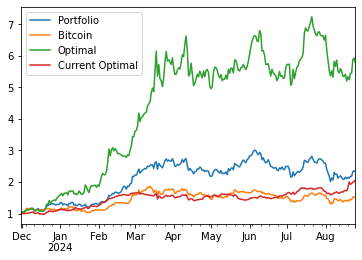

In [34]:
(1+portfolio_perf).cumprod().plot()

In [35]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<AxesSubplot:>

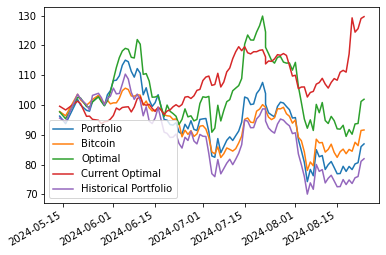

In [36]:
((1+current_perf.iloc[:]).cumprod()*100).plot()

In [37]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2024-08-15,76.926351,82.419706,91.992248,108.314624,72.556810
2024-08-16,76.993467,84.308022,91.897334,110.998979,72.618520
2024-08-17,79.419035,85.187517,93.188550,111.630060,74.962292
2024-08-18,77.705291,83.649236,89.458966,111.032154,73.291076
2024-08-19,79.369217,85.084495,91.759403,117.120615,74.846347
2024-08-20,78.328816,84.474367,90.184589,129.249811,73.655834
2024-08-21,80.220711,87.486482,93.644862,124.455997,75.569469
2024-08-22,80.634042,86.363205,93.794585,125.625118,76.000152
2024-08-23,86.015347,91.447904,101.173261,129.037497,81.091030
2024-08-24,86.937085,91.618781,101.922915,129.653010,81.955343


<AxesSubplot:>

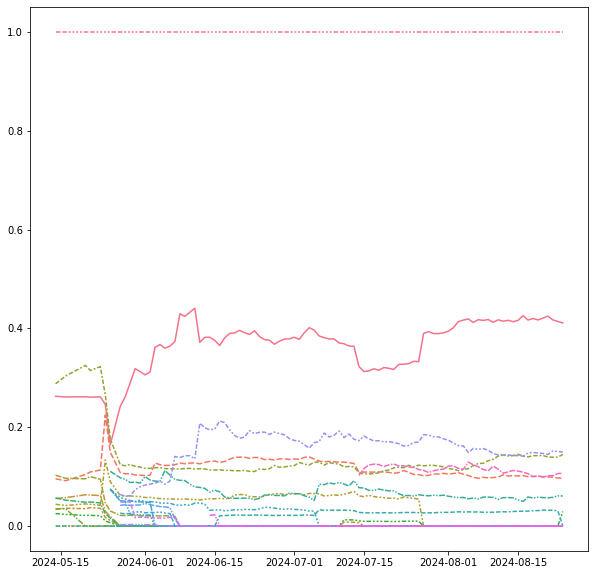

In [38]:
plt.figure(figsize=(10,10))
sns.lineplot(data=weights_ex_post,legend=False,linestyle='solid')

In [39]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)

vol

Portfolio    0.687827
dtype: float64

In [40]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)

vol

Portfolio    0.563454
dtype: float64

In [41]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.522860
Bitcoin            0.451261
Optimal            0.689071
Current Optimal    0.323427
dtype: float64

In [42]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.27030613020934197

In [43]:
perf_analysis=pd.concat([historical_risk.perf_contrib_pct(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution in %,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,0.017742,0.028451,0.036620,0.006008,0.030612
BTCUSDT,0.029303,0.074530,0.174988,0.068619,0.106369
JASMYUSDT,0.003907,0.005921,0.012993,0.001129,0.011864
OMUSDT,0.928780,0.865723,0.717161,0.612895,0.104266
PEPEUSDT,0.020269,0.025375,0.058238,0.014576,0.043662


In [44]:
perf_analysis=pd.concat([current_risk.perf_contrib_pct(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution in %,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,0.210738,0.423287,0.289362,0.101416,0.187946
SOLUSDT,0.099759,0.150285,0.161989,0.034946,0.127042
JASMYUSDT,0.156556,0.148223,0.242081,0.080909,0.161172
OMUSDT,-0.475898,0.119879,0.101247,0.024736,0.076511
ETHUSDT,0.342673,0.090165,0.082795,0.009932,0.072863
BBUSDT,0.907406,0.028624,0.117605,0.026918,0.090687
TRXUSDT,-0.241234,0.039538,0.004922,0.000298,0.004623


## Value At Risk

### Historical

In [45]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.05884649741344634, -0.08171778896778559)

In [46]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.052653624591299, -0.0703263164089755)

In [47]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [48]:
var=historical_var.iloc[row]
var

BTCUSDT     -0.017296
SOLUSDT     -0.012345
JASMYUSDT   -0.011485
OMUSDT      -0.004358
ETHUSDT     -0.004485
BBUSDT      -0.002453
TRXUSDT     -0.001225
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
Portfolio   -0.053647
Name: 2024-07-07 00:00:00, dtype: float64

In [49]:
cvar=historical_var.iloc[:row+1].mean()
cvar

BTCUSDT     -0.020769
SOLUSDT     -0.011938
JASMYUSDT   -0.016289
OMUSDT      -0.008435
ETHUSDT     -0.005988
BBUSDT      -0.006167
TRXUSDT     -0.000741
BNBUSDT      0.000000
PEPEUSDT     0.000000
Portfolio   -0.070326
dtype: float64

### Parametric

In [50]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.07139881851495827, -0.09151354465616042)

In [51]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.05838286916670533, -0.07483069630238659)

### Multivariate

In [52]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.06412610950073712, -0.08177290264204828)

In [53]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.058754972165993354, -0.07274028818615669)

In [54]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

mean_scenario_multivariate=pd.DataFrame(scenario_multivariate).T.mean()
mean_scenario_multivariate

BTCUSDT     -0.018043
SOLUSDT     -0.009410
JASMYUSDT   -0.012699
OMUSDT      -0.005702
ETHUSDT     -0.005110
BBUSDT      -0.006629
TRXUSDT     -0.000222
Portfolio   -0.057816
dtype: float64

### Copulas

In [55]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06311767142319336, -0.08116362826371941)

In [56]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05724664986513211, -0.07157464895935918)

In [57]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gaussian).T.mean()
mean_scenario_gaussian

BTCUSDT     -0.017504
SOLUSDT     -0.009305
JASMYUSDT   -0.013656
OMUSDT      -0.005156
ETHUSDT     -0.004714
BBUSDT      -0.007230
TRXUSDT     -0.000139
Portfolio   -0.057704
dtype: float64

In [58]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06268676456792567, -0.08170942287639299)

In [59]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05892948800970486, -0.07564069468472426)

In [60]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_t_copula).T.mean()
mean_scenario_gaussian

BTCUSDT     -0.016676
SOLUSDT     -0.009240
JASMYUSDT   -0.014383
OMUSDT      -0.005294
ETHUSDT     -0.005018
BBUSDT      -0.007990
TRXUSDT     -0.000264
Portfolio   -0.058864
dtype: float64

In [61]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.12345334602295688, -0.17475624725507857)

In [62]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06504533516334893, -0.0885293756056926)

In [63]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gumbel_copula).T.mean()
mean_scenario_gaussian

BTCUSDT     -0.025324
SOLUSDT     -0.006793
JASMYUSDT   -0.018646
OMUSDT      -0.003290
ETHUSDT     -0.002373
BBUSDT      -0.007649
TRXUSDT      0.000019
Portfolio   -0.064057
dtype: float64

### Monte Carlo

In [64]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [65]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07425473886392893, -0.0922682718276503)

In [66]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.059102977570743856, -0.07436318539074924)

In [67]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results
    
mean_scenario_monte_carlo=pd.DataFrame(scenario_monte_carlo).T.mean()
mean_scenario_monte_carlo

BTCUSDT     -0.016996
SOLUSDT     -0.009508
JASMYUSDT   -0.013713
OMUSDT      -0.006485
ETHUSDT     -0.005101
BBUSDT      -0.007635
TRXUSDT     -0.000221
Portfolio   -0.059658
dtype: float64

### VaR Violation

In [68]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.056685,-0.097358,-0.082294,-0.023880
2024-01-15,-0.056685,-0.097380,-0.083122,0.019583
2024-01-16,-0.056685,-0.097719,-0.080656,0.052384
2024-01-17,-0.056685,-0.099926,-0.086943,-0.032775
2024-01-18,-0.056685,-0.101837,-0.091976,-0.031415
...,...,...,...,...
2024-08-21,-0.067593,-0.081333,-0.088443,0.038369
2024-08-22,-0.067593,-0.081291,-0.086832,0.001599
2024-08-23,-0.067593,-0.088787,-0.093844,0.078668
2024-08-24,-0.067593,-0.088885,-0.090722,0.007410


In [69]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.035853,-0.089584,-0.079476,-0.018088
2024-05-29,-0.026802,-0.085923,-0.073857,-0.014397
2024-05-30,-0.026802,-0.074002,-0.067621,0.036336
2024-05-31,-0.025679,-0.070641,-0.058660,0.013186
2024-06-01,-0.025679,-0.070724,-0.061496,0.032115
...,...,...,...,...
2024-08-21,-0.052419,-0.093143,-0.091522,0.024153
2024-08-22,-0.052419,-0.091205,-0.085179,0.005152
2024-08-23,-0.052419,-0.070985,-0.069093,0.066737
2024-08-24,-0.052167,-0.068575,-0.064497,0.010716


<AxesSubplot:>

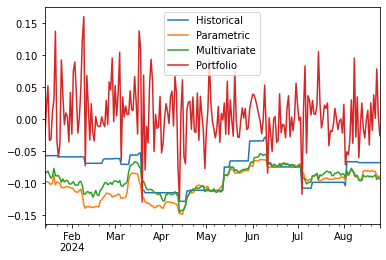

In [70]:
var_data.plot()

<AxesSubplot:>

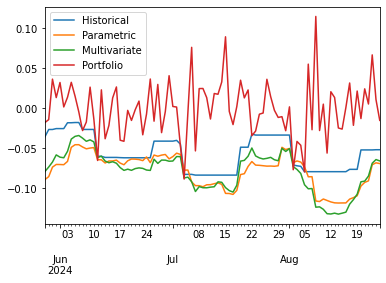

In [71]:
current_var_data.plot()

In [72]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.022222,0.013333,0.013333
Kupiec Stat,4.571691,8.883867,8.883867
P-value,0.032504,0.002877,0.002877


In [73]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.077778,0.044444,0.033333
Kupiec Stat,1.259481,0.060654,0.593373
P-value,0.261749,0.805465,0.441118


## Principal Component Analysis

In [74]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.78249833, 0.06654165, 0.05408255, 0.05165113, 0.04522634])

In [75]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.66148774, 0.14516453, 0.08617701, 0.07447875, 0.03269197])

In [76]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))

<AxesSubplot:>

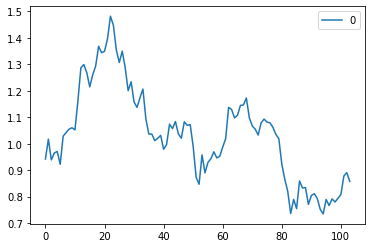

In [77]:
x=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)))
x=x.dropna()
(1+x).cumprod().plot()

<AxesSubplot:>

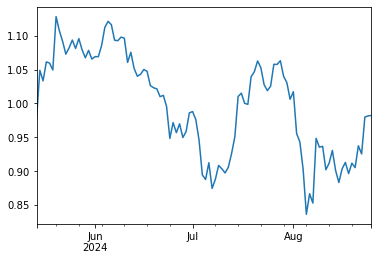

In [78]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()